In [3]:
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
import torch
import matplotlib.pyplot as plt
from torch.nn import Linear, ReLU
from torch_geometric.nn import Sequential, GCNConv
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
dataset = QM9(root='./raw/qm9')
batch_size = 64

In [12]:
from torch.utils.data import random_split
dataloader1 = DataLoader(dataset, batch_size=64, shuffle=True)
dataloader2 = DataLoader(dataset, batch_size=128, shuffle=True)
# Define the sizes of train, test, and validation sets
train_size = int(0.7 * len(dataset))
test_size = int(0.2 * len(dataset))
val_size = len(dataset) - train_size - test_size

# Split the dataset into train, test, and validation sets
train_dataset, test_dataset, val_dataset = random_split(dataset, [train_size, test_size, val_size])

# Create dataloaders for train, test, and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [13]:
#maximum absolute value of each y in the dataset
y_norm = torch.tensor([2.9556e+01, 1.9662e+02, 1.1663e+01, 5.2654e+00, 1.6928e+01, 3.3748e+03,
        7.4544e+00, 1.9444e+04, 1.9444e+04, 1.9444e+04, 1.9445e+04, 4.6969e+01,
        1.1311e+02, 1.1389e+02, 1.1461e+02, 1.0482e+02, 6.1987e+05, 4.3790e+02,
        2.8295e+02]).to(device)

In [14]:
in_channels = dataset.num_features
out_channels = dataset.num_classes

In [15]:
#A simple model that uses 2 GCN layers and ReLU activation
model = Sequential('x, edge_index', [
    (GCNConv(in_channels, 64), 'x, edge_index -> x'),
    ReLU(inplace=True),
    (GCNConv(64, 64), 'x, edge_index -> x'),
    ReLU(inplace=True),
    Linear(64, out_channels),
])
model = model.to(device)

In [17]:
def compute_loss_loader(loader, model):
    loss = torch.nn.L1Loss()
    with torch.no_grad():
        li_loss = []
        for data in loader:
            data = data.to(device)
            y_hat = model(data.x, data.edge_index)
            # normalization
            y = data.y / y_norm
            idx = data.batch.to(device)
            idx = idx.unsqueeze(1).repeat(1, y_hat.size(1))
            out = torch.zeros(torch.max(idx)+1, y_hat.size(1), device=device)
            out = out.scatter_add_(0, idx, y_hat)
            count = torch.zeros(torch.max(idx)+1, y_hat.size(1),device=device)
            count = count.scatter_add_(0, idx, torch.ones_like(y_hat,device=device))
            out = torch.div(out, count)
            l = loss(out, y)
            li_loss.append(l.item())
    return sum(li_loss)/len(li_loss)

In [18]:
li_loss_train = []
li_loss_test = []
loss = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
for epoch in range(100):
    model.train()
    li_loss_mean = []
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        y_hat = model(data.x, data.edge_index)
        # normalization
        y = data.y / y_norm 
        # computation of the values
        idx = data.batch.to(device)
        idx = idx.unsqueeze(1).repeat(1, y_hat.size(1))
        out = torch.zeros(torch.max(idx)+1, y_hat.size(1), device=device)
        out = out.scatter_add_(0, idx, y_hat)
        count = torch.zeros(torch.max(idx)+1, y_hat.size(1),device=device)
        count = count.scatter_add_(0, idx, torch.ones_like(y_hat,device=device))
        out = torch.div(out, count)
        l = loss(out, y)
        l.backward()
        optimizer.step()
        li_loss_mean.append(l.item())
    li_loss_train.append(sum(li_loss_mean)/len(li_loss_mean))
    li_loss_test.append(compute_loss_loader(test_loader, model))
    print(f'epoch {epoch} loss {li_loss_train[-1]}')

epoch 0 loss 0.035683369416298356
epoch 1 loss 0.02988653943192534
epoch 2 loss 0.028269670112286305
epoch 3 loss 0.026312646743074153
epoch 4 loss 0.025609895813452622
epoch 5 loss 0.02526445867614801
epoch 6 loss 0.025136052347735287
epoch 7 loss 0.024900150117623813
epoch 8 loss 0.02475501199016656
epoch 9 loss 0.02458280397567359
epoch 10 loss 0.0243921457906335
epoch 11 loss 0.024244205316803324
epoch 12 loss 0.024165144485664234
epoch 13 loss 0.02414154266296859
epoch 14 loss 0.024070819619858207
epoch 15 loss 0.024001308647195914
epoch 16 loss 0.023983102843717293
epoch 17 loss 0.023954276439351774
epoch 18 loss 0.023894489112171485
epoch 19 loss 0.023866468263434665
epoch 20 loss 0.023810851519795916
epoch 21 loss 0.0237738581635917
epoch 22 loss 0.023708854753141384
epoch 23 loss 0.02370798663944943
epoch 24 loss 0.023704232668841245
epoch 25 loss 0.023648211728601834
epoch 26 loss 0.02365917822959163
epoch 27 loss 0.02365757621678958
epoch 28 loss 0.02362600890080009
epoch 29

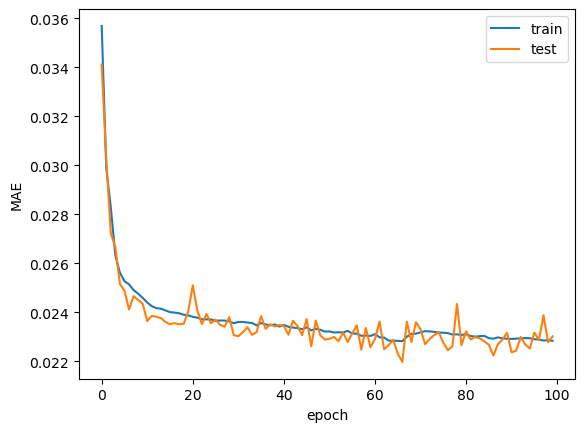

In [21]:
plt.figure()
plt.plot(li_loss_train, label='train')
plt.plot(li_loss_test, label='test')
plt.xlabel('epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [22]:
val_loss = compute_loss_loader(val_loader, model)
print(f'validation loss {val_loss}')

validation loss 0.023188217029702373
